In [ ]:
ENV["LIBTENSORFLOW"]="/usr/local/cuda-8.0/targets/x86_64-linux/lib/libtensorflow"
ENV["TF_USE_GPU"]="1"
Pkg.build("TensorFlow")
using TensorFlow
using CSV: read
using Distributions: Normal
using ProgressMeter: @showprogress
using PyPlot: plot

In [2]:
# Preprocessing the data
f = CSV.read("./gyroscope.csv")

T = length(f[:,11])
Nw = 3                          # Window size
Nc = 3                          # number of inputs
Ncw = Nc * Nw                   # input size
TNw = Int64(floor(T/Nw/3))        # number of time stamps

dim1 =  Int64(floor(Ncw / 2))
dim2 =  Int64(floor(dim1 / 2))

raw_train = Array{Float32, 2}(Nc,T)
raw_train = f[:,11:13]

s = Array{Float32, 2}(Ncw,TNw)
for i=1:TNw
    s[:,i] .= vec(convert(Array,f[Nw*(i-1)+1:Nw*i,11:13]))
end
s

9×2709 Array{Float32,2}:
 -0.0082558   -0.0066579   -0.00292948  …  -0.0292948  -0.0298274 
 -0.00532632  -0.00585895  -0.00292948     -0.0319579  -0.0245011 
 -0.00346211  -0.00452737  -0.00692422     -0.0327569  -0.0165116 
  0.0215716    0.0149137    0.0218379      -0.0332895  -0.0130495 
  0.0205063    0.0143811    0.0186421      -0.0300937  -0.00426106
  0.0191748    0.0191748    0.0125169   …  -0.0237021  -0.00559264
 -0.00186421  -0.00239685  -0.00692422      0.0146474   0.0066579 
 -0.0015979   -0.0015979   -0.00905475      0.0135821   0.00292948
 -0.00292948  -0.00532632  -0.00878843      0.010919   -0.00239685

In [3]:
function weight_variable(shape, λ=0.1, reg=nn.l2_loss)
    W = Variable(map(Float64, rand(Normal(0, .01), shape...)))
    # regularization term
    wd = λ * reg(W)
    TensorFlow.add_to_collection(:regularizers, wd)
    return W
end

function bias_variable(shape)
    b = Variable(fill(Float64(.1), shape...))
    return b
end

# returns a tensor that computes the autoencoder output for a timestamp t of the input array s
function autoencoder(input)
    enc = nn.sigmoid(W2 * nn.sigmoid(W1 * input + b1) + b2)
    TensorFlow.add_to_collection(:encoders, enc)
    return nn.sigmoid(W1t * nn.sigmoid(W2t * enc + b3) + b4)
end

autoencoder (generic function with 1 method)

In [4]:
g = Graph()
sess = Session(g)

@tf begin
    
    x = placeholder(Float64, shape=[Ncw, 1])
        
    W1 = weight_variable([dim1, Ncw])
    b1 = bias_variable([dim1, 1])

    W2 = weight_variable([dim2, dim1])
    b2 = bias_variable([dim2, 1])

    # this is a tied weight
    W2t = transpose(W2)
    b3 = bias_variable([dim1, 1])

    # this is a tied weight too
    W1t = transpose(W1)
    b4 = bias_variable([Ncw, 1])
    
end

2018-07-13 17:14:35.907848: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-07-13 17:14:35.997274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-07-13 17:14:35.997612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1404] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.86
pciBusID: 0000:01:00.0
totalMemory: 7.92GiB freeMemory: 7.54GiB
2018-07-13 17:14:35.997621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1483] Adding visible gpu devices: 0
2018-07-13 17:14:36.163501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:964] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-07-13 17:14:36.163523: I tensorflow/core/common_runtime/gpu/gpu_device

TensorFlow.Variables.Variable{Float64}(<Tensor node_6:1 shape=(9, 1) dtype=Float64>, <Tensor node_6/Assign:1 shape=unknown dtype=Float64>)

In [5]:
# initialize input as a matrix; passing vectors does not work
input = Array{Any, 2}(Ncw,1)

@tf begin
    data = constant(s)

    # iterate over all time windows
    @showprogress for i=1:TNw
        # input is the i-th column of the data
        input = slice(data,[1,i],[Ncw,1])
        TensorFlow.add_to_collection(:losses, reduce_mean((autoencoder(input) - input)^2 ))
    end
    # add MSE and regularization loss for total loss
    loss = reduce_sum(stack(get_collection(:losses))) + reduce_sum(stack(get_collection(:regularizers)))  
    
    
    # iterate over all time windows again; calling get_collection before a collection has been
    # populated does not give a reference to the Array that will be populated by add_to_collection
    code = get_collection(:encoders)
    @showprogress for i=2:TNw
        TensorFlow.add_to_collection(:dists, nn.l2_loss(code[i]-code[i-1])/sqrt(multiply(nn.l2_loss(code[i]),nn.l2_loss(code[i-1]))))
    end  
    # concatenate encoder outputs to build the code
    dist = stack(get_collection(:dists))'
    
    opt = train.AdamOptimizer(1e-4)
    optimizer = train.minimize(opt, loss)
    
    saver = train.Saver()
    save_path = "./checkpoints/tensorflow_emax1e3"
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Typically, executing `pip install --upgrade tensorflow` from the command line will upgrade Python TensorFlow. You may need admninistrator privileges.


"./checkpoints/tensorflow_emax1e3"

In [ ]:
# train new network
run(sess, global_variables_initializer())

emax = Int32(1e4)
tic()
for epoch=1:emax
    cur_loss, _ = run(sess, (loss, optimizer))
    cur_loss = Float32(cur_loss)
    if epoch%(emax/10) == 0 || epoch <= 10
        elapsed = toq(); tic()
        info("epoch: $(@sprintf("%5i", epoch)) | elapsed time: $(@sprintf("%6.1f", elapsed)) seconds | loss: $(@sprintf("%.6f", cur_loss)) | accuracy: ...")
    end
end

train.save(saver, sess, save_path)

In [6]:
# reuse weights from a previously stored network
run(sess, global_variables_initializer())
train.restore(saver, sess, save_path)
run(sess, loss)

536.140982167554

In [10]:
save_path = "./checkpoints/tensorflow_emax5e3"
emax = Int32(4e3)
tic()
for epoch=1:emax
    cur_loss, _ = run(sess, (loss, optimizer))
    cur_loss = Float32(cur_loss)
    if epoch%(emax/10) == 0 || epoch <= 10
        elapsed = toq(); tic()
        info("epoch: $(@sprintf("%5i", epoch)) | elapsed time: $(@sprintf("%6.1f", elapsed)) seconds | loss: $(@sprintf("%.6f", cur_loss)) | accuracy: ...")
    end
end

train.save(saver, sess, save_path)

INFO: epoch:     1 | elapsed time:  106.3 seconds | loss: 536.140991 | accuracy: not implemented
INFO: epoch:     2 | elapsed time:  106.7 seconds | loss: 535.926941 | accuracy: not implemented
INFO: epoch:     3 | elapsed time:  107.0 seconds | loss: 535.712952 | accuracy: not implemented
INFO: epoch:     4 | elapsed time:  107.2 seconds | loss: 535.499023 | accuracy: not implemented
INFO: epoch:     5 | elapsed time:  107.5 seconds | loss: 535.285034 | accuracy: not implemented
INFO: epoch:     6 | elapsed time:  107.8 seconds | loss: 535.071167 | accuracy: not implemented
INFO: epoch:     7 | elapsed time:  108.1 seconds | loss: 534.857239 | accuracy: not implemented
INFO: epoch:     8 | elapsed time:  108.4 seconds | loss: 534.643372 | accuracy: not implemented
INFO: epoch:     9 | elapsed time:  108.6 seconds | loss: 534.429565 | accuracy: not implemented
INFO: epoch:    10 | elapsed time:  108.9 seconds | loss: 534.215759 | accuracy: not implemented
INFO: epoch:   400 | elapsed t

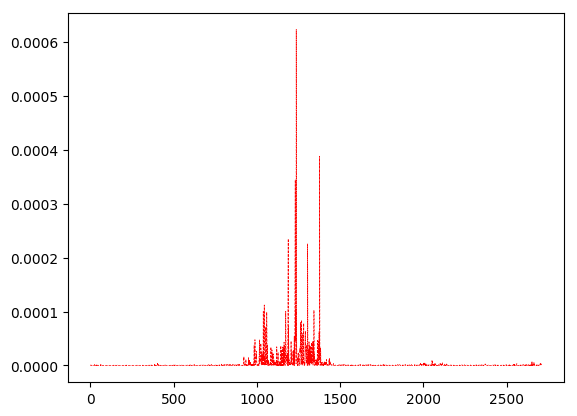

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb4e44ead68>

In [11]:
x = linspace(1,TNw-1,TNw-1); y = run(sess,dist)
plot(x,y, color="red", linewidth=0.5, linestyle="--")

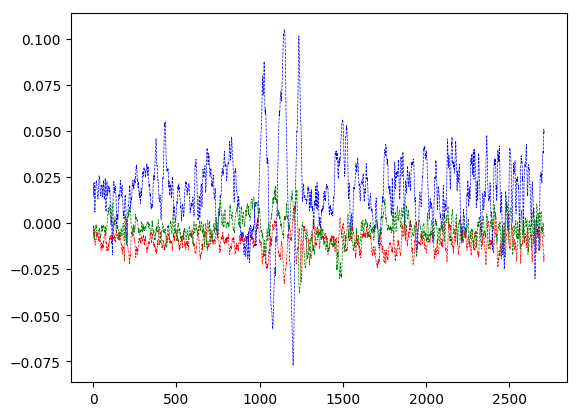

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb4a401aeb8>

In [9]:
x = linspace(1,TNw,TNw);
y1 = f[1:TNw,11]
y2 = f[1:TNw,12]
y3 = f[1:TNw,13]
plot(x,y1, color="red", linewidth=0.5, linestyle="--")
plot(x,y2, color="blue", linewidth=0.5, linestyle="--")
plot(x,y3, color="green", linewidth=0.5, linestyle="--")